In [1]:
%pip install opencv-contrib-python
%pip install matplotlib
%pip install deepface

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [23]:
import cv2
import matplotlib.pyplot as plt
from deepface import DeepFace


In [3]:
img = cv2.imread('happyboy.jpg')

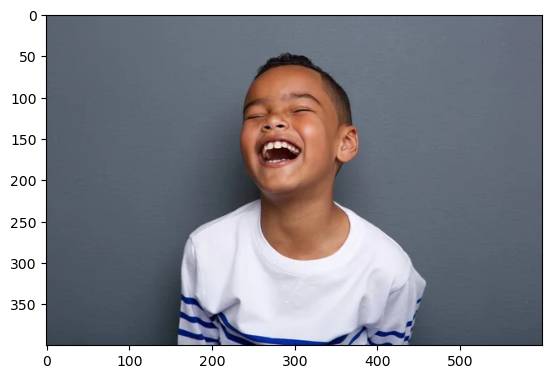

In [4]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [5]:
predictions = DeepFace.analyze(img)

Action: race: 100%|██████████| 4/4 [00:41<00:00, 10.26s/it]   


In [6]:
predictions

[{'emotion': {'angry': 5.033397336107624e-16,
   'disgust': 6.13691116335509e-32,
   'fear': 1.1570550527623732e-13,
   'happy': 100.0,
   'sad': 4.833625904046568e-11,
   'surprise': 1.0650399451250792e-07,
   'neutral': 5.6200785128121544e-12},
  'dominant_emotion': 'happy',
  'region': {'x': 213,
   'y': 60,
   'w': 145,
   'h': 145,
   'left_eye': None,
   'right_eye': None},
  'face_confidence': 0.94,
  'age': 40,
  'gender': {'Woman': 5.8974988758563995, 'Man': 94.10249590873718},
  'dominant_gender': 'Man',
  'race': {'asian': 81.48214221000671,
   'indian': 4.98429611325264,
   'black': 1.7998931929469109,
   'white': 3.5243432968854904,
   'middle eastern': 1.2207270599901676,
   'latino hispanic': 6.98859766125679},
  'dominant_race': 'asian'}]

In [7]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [8]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = faceCascade.detectMultiScale(gray,1.1,4)

for(x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0,255, 0), 2)

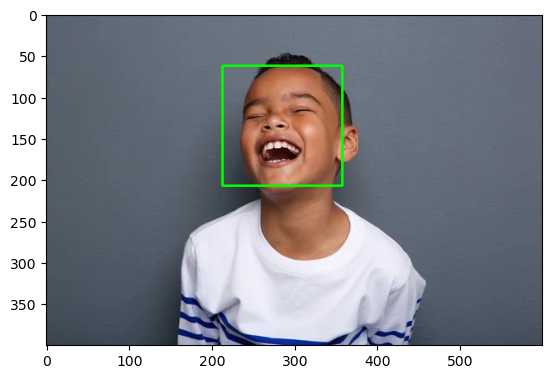

In [9]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [10]:
font = cv2.FONT_HERSHEY_SIMPLEX

cv2.putText(img, predictions[0]['dominant_emotion'], (50, 50), font, 1, (0,0,255), 2, cv2.LINE_4);

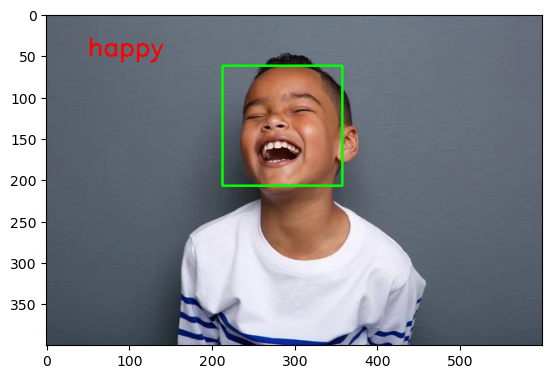

In [11]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [12]:
## Real-time Emotion Detector

In [38]:
import cv2
import mediapipe as mp
import numpy as np
from scipy.spatial import distance as dist
from playsound import playsound
import os

# Initialize Mediapipe Face Mesh
mp_face_detection = mp.solutions.face_detection
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True)

# Eye Aspect Ratio (EAR) calculation
def calculate_EAR(eye_landmarks):
    A = dist.euclidean(eye_landmarks[1], eye_landmarks[5])  # Vertical distance 1
    B = dist.euclidean(eye_landmarks[2], eye_landmarks[4])  # Vertical distance 2
    C = dist.euclidean(eye_landmarks[0], eye_landmarks[3])  # Horizontal distance

    # Calculate the EAR
    ear = (A + B) / (2.0 * C)
    return ear

# Thresholds
EAR_THRESHOLD = 0.21  # Eye Aspect Ratio threshold for detecting closed eyes
CONSECUTIVE_FRAMES_THRESHOLD = 30  # Consecutive frames to determine "sleeping"

ALERT_SOUND_PATH = "alert.wav"

# Open webcam
cap = cv2.VideoCapture(0)

# Initialize variables
eyes_closed_counter = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to RGB for Mediapipe processing
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = face_mesh.process(rgb_frame)

    # Detect face landmarks
    if result.multi_face_landmarks:
        for face_landmarks in result.multi_face_landmarks:
            # Get face bounding box coordinates for drawing a rectangle around the face
            face_x = min([int(landmark.x * frame.shape[1]) for landmark in face_landmarks.landmark])
            face_y = min([int(landmark.y * frame.shape[0]) for landmark in face_landmarks.landmark])
            face_w = max([int(landmark.x * frame.shape[1]) for landmark in face_landmarks.landmark]) - face_x
            face_h = max([int(landmark.y * frame.shape[0]) for landmark in face_landmarks.landmark]) - face_y
            
            # Draw a green rectangle around the face
            cv2.rectangle(frame, (face_x, face_y), (face_x + face_w, face_y + face_h), (0, 255, 0), 2)

            # Left eye landmarks (using the relevant indices from Mediapipe's face mesh)
            left_eye = [(face_landmarks.landmark[i].x * frame.shape[1], face_landmarks.landmark[i].y * frame.shape[0])
                        for i in [362, 385, 387, 263, 373, 380]]
            # Right eye landmarks
            right_eye = [(face_landmarks.landmark[i].x * frame.shape[1], face_landmarks.landmark[i].y * frame.shape[0])
                         for i in [33, 160, 158, 133, 153, 144]]

            # Calculate EAR for both eyes
            left_EAR = calculate_EAR(left_eye)
            right_EAR = calculate_EAR(right_eye)

            # Draw red rectangles around the eyes (bounding boxes)
            left_eye_x = int(min([point[0] for point in left_eye]))
            left_eye_y = int(min([point[1] for point in left_eye]))
            left_eye_w = int(max([point[0] for point in left_eye])) - left_eye_x
            left_eye_h = int(max([point[1] for point in left_eye])) - left_eye_y
            cv2.rectangle(frame, (left_eye_x, left_eye_y), (left_eye_x + left_eye_w, left_eye_y + left_eye_h), (0, 0, 255), 2)

            right_eye_x = int(min([point[0] for point in right_eye]))
            right_eye_y = int(min([point[1] for point in right_eye]))
            right_eye_w = int(max([point[0] for point in right_eye])) - right_eye_x
            right_eye_h = int(max([point[1] for point in right_eye])) - right_eye_y
            cv2.rectangle(frame, (right_eye_x, right_eye_y), (right_eye_x + right_eye_w, right_eye_y + right_eye_h), (0, 0, 255), 2)

            # Average EAR of both eyes
            avg_EAR = (left_EAR + right_EAR) / 2.0

            # If EAR is below the threshold, count closed eyes
            if avg_EAR < EAR_THRESHOLD:
                eyes_closed_counter += 1
            else:
                eyes_closed_counter = 0

            # Determine sleep status
            if eyes_closed_counter >= CONSECUTIVE_FRAMES_THRESHOLD:
                sleep_status = "Sleeping"
            else:
                sleep_status = "Awake"

            # Display the sleep/awake status on the frame
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(frame, sleep_status, (50, 100), font, 2, (0, 0, 255), 2, cv2.LINE_4)

    # Display the frame
    cv2.imshow('Video', frame)

    # Break loop if 'q' is pressed
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

# Release webcam and close windows
cap.release()
cv2.destroyAllWindows()
